# PanAnalysis Test Data

## Import required modules

Import the modules required for this solution

In [1]:
import pyodbc
import pandas as pd

## Connect to data source

In [2]:
s_server = '169.254.250.189\SQLEXPRESS'
s_database = 'PanAnalysis'
s_user = 'sa'
s_password = 'Demo'

s_connection = 'DRIVER={SQL Server Native Client 11.0};' 
s_connection += 'SERVER=' + s_server + ';DATABASE=' + s_database +';'
s_connection += 'UID=' + s_user +';PWD=' + s_password

dbconn = pyodbc.connect(s_connection)

print('Database connection made...')

Database connection made...


## Load data into dataframe

In [5]:
# Read in the data set to a data frame
s_tmpsql = 'select * from zTempPanAnalysis'
df_initial = pd.read_sql_query(s_tmpsql, dbconn)

In [7]:
# Check we have this OK
df_initial[0:3]

,ID,Incident,IncidentType,CustomerId,LedgerCode,BusinessType,SiteId,MachinesOnSite,SoleMachine,Manufacturer,...,AttendHour,AttendOnSite,AttendTimeValid,CallMinutes,MinutesToAttend,MinutesToAttendValid,PostCodeArea,FirstEngineer,SymptomCodeId,SymptomDescription
0,1,145001,BREAKDOWN,12473,S798,Education - Junior/Primary school,21019,4,False,TOSHIBA,...,11,True,True,52,769,True,DE23,BEN,S44,Connectivity
1,2,145002,BREAKDOWN,11546,F119,Education - Junior/Primary school,20497,1,True,TOSHIBA,...,12,True,True,161,814,True,BD10,SERING,S44,Connectivity
2,4,145004,BREAKDOWN,10751,BS036,Education - Junior/Primary school,23322,2,False,TOSHIBA,...,10,True,True,70,688,True,BD13,RONNIE,S44,Connectivity


## Shape the data ready for model building
We will need:
- Categorical values to be one-hot encoded - this is for decision tree work and deep learning
- Scaling and normalisation of scalar quantities - this is for deep learning only

Objective is to produce a data frame for decision trees and a data frame for deep learning.

The data frame for deep learning may require data augmentation to balance the training set (REPEATS / non-REPEATS)

### Decision tree data frame
Prepare a data frame for the decision tree work

In [25]:
# Make a copy of the main data frame
df_tree = df_initial.copy()

Categoricals to encode are:
- Business type
- Manufacturer
- Product Id (this is going to generate a *lot* of columns)
- Device Type
- LastOtherCallType
- CreatedBy (lots)
- PostCodeArea (another large set)
- FirstEngineer
- SymptomCodeId (lots)

In [26]:
# One-hot encoding for engineers
one_hot = pd.get_dummies(df_tree['BusinessType'])
print(one_hot[0:10])

   Agriculture  Charity  Education - Institution/Organisation  \
0            0        0                                     0   
1            0        0                                     0   
2            0        0                                     0   
3            0        0                                     0   
4            0        0                                     0   
5            0        0                                     0   
6            0        0                                     0   
7            0        0                                     0   
8            0        0                                     0   
9            0        0                                     0   

   Education - Junior/Primary school  Education - Nursery/Pre school  \
0                                  1                               0   
1                                  1                               0   
2                                  1                               0

In [27]:
# Now do the join to augment the data frame
df_tree = df_tree.join(one_hot)
df_tree[0:3]

,ID,Incident,IncidentType,CustomerId,LedgerCode,BusinessType,SiteId,MachinesOnSite,SoleMachine,Manufacturer,...,Trades - Plumbing,Trades - Printers,Trades - Security Systems,Trades - Shopfitters,Transport - Logistics/ Haulage/Distribution,Transport - People/Air/Car/Train,Travel,UNKNOWN,Utilities - Water/Gas/Electric/Waste,Veterinary/Animal services
0,1,145001,BREAKDOWN,12473,S798,Education - Junior/Primary school,21019,4,False,TOSHIBA,...,0,0,0,0,0,0,0,0,0,0
1,2,145002,BREAKDOWN,11546,F119,Education - Junior/Primary school,20497,1,True,TOSHIBA,...,0,0,0,0,0,0,0,0,0,0
2,4,145004,BREAKDOWN,10751,BS036,Education - Junior/Primary school,23322,2,False,TOSHIBA,...,0,0,0,0,0,0,0,0,0,0


Now do the same process for each of the fields we want to one-hot encode

Now create the target value for the model

In [9]:
y_repeat = df_tree['IncidentType'].map(lambda x: x == 'REPEAT')

In [20]:
# Just show a few values - there will be few 'True' values as REPEATS are sparse
print(df_tree['IncidentType'][0:5])
print(y_repeat[0:5])

0    BREAKDOWN
1    BREAKDOWN
2    BREAKDOWN
3    BREAKDOWN
4    BREAKDOWN
Name: IncidentType, dtype: object
0    False
1    False
2    False
3    False
4    False
Name: IncidentType, dtype: bool


Now drop off fields which are not going to be used in the model process.

Drop the field which have been one-hot encoded.

Fields which are not useful and can also be dropped are:
- ID
- Incident (incident code)
- 

## (Below here is nurdling...)

In [3]:
# Simple database query test
s_tmpsql = 'select top 10 * from zTempPanAnalysis'
dbcursor = dbconn.cursor()
dbcursor.execute(s_tmpsql)
dbrecordset = dbcursor.fetchall()
for record in dbrecordset:
    print('Incident ID :', record.Incident)

print('\nShould have printed 10 6-digit incident IDs.')

Incident ID : 145001
Incident ID : 145002
Incident ID : 145004
Incident ID : 145005
Incident ID : 145007
Incident ID : 145008
Incident ID : 145009
Incident ID : 145011
Incident ID : 145013
Incident ID : 145014

Should have printed 10 6-digit incident IDs.


## Load some data into a dataframe

In [4]:
data_array = []
for record in dbrecordset:
    data_array += [[record.Incident, record.IncidentType, record.CustomerId]]
print('Data array looks like:\n')
print(data_array)

Data array looks like:

[['155059', 'BREAKDOWN', '10023'], ['155060', 'RTF', '12421'], ['155061', 'BREAKDOWN', '12190'], ['155063', 'BREAKDOWN', '11946'], ['155065', 'BREAKDOWN', '12571'], ['155066', 'BREAKDOWN', '10879'], ['155067', 'BREAKDOWN', '11668'], ['155068', 'REPEAT', '13051'], ['155069', 'BREAKDOWN', '11042'], ['155070', 'RTF', '12046']]


In [5]:
df = pd.DataFrame(data_array, columns=['Incident','IncidentType','CustomerId'])
print('Data frame looks like:\n')
print(df)

Data frame looks like:

  Incident IncidentType CustomerId
0   155059    BREAKDOWN      10023
1   155060          RTF      12421
2   155061    BREAKDOWN      12190
3   155063    BREAKDOWN      11946
4   155065    BREAKDOWN      12571
5   155066    BREAKDOWN      10879
6   155067    BREAKDOWN      11668
7   155068       REPEAT      13051
8   155069    BREAKDOWN      11042
9   155070          RTF      12046


In [6]:
# Get the columns from the recordset
s_cols = [col[0] for col in dbcursor.description]
print('Columns list:\n', s_cols)

Columns list:
 ['ID', 'Incident', 'IncidentType', 'CustomerId', 'LedgerCode', 'BusinessType', 'SiteId', 'MachinesOnSite', 'SoleMachine', 'Manufacturer', 'SerialNo', 'ProductId', 'DeviceType', 'Colour', 'AncilliariesCount', 'FirstUsed', 'FirstUsedDays', 'Installed', 'InstalledDays', 'PreviousBreakdowns', 'LastBreakCall', 'LastBreakCallDays', 'LastOtherCall', 'LastOtherCallDays', 'LastOtherCallType', 'InitialMeterValueBlack', 'InitialMeterValueColour', 'InitialMeterReadingDate', 'LastMeterValueBlack', 'LastMeterValueColour', 'LastMeterReadingDate', 'BlackClickPerDay', 'ColourClickPerDay', 'TotalClickPerDay', 'CreatedBy', 'CreatedDateTime', 'CreatedTime', 'CreatedDay', 'AttendDateTime', 'AttendDay', 'AttendHour', 'CallMinutes', 'MinutesToAttend', 'PostCodeArea', 'FirstEngineer']


In [7]:
# This should fetch some rows and give the sensible column names
s_tmpsql2 = 'select top 10 * from zTempPanAnalysis'
df2 = pd.read_sql_query(s_tmpsql2, dbconn)

In [8]:
print(df2)


     ID Incident IncidentType CustomerId LedgerCode  \
0  1796   155059    BREAKDOWN      10023       M440   
1  1797   155060          RTF      12421       T278   
2  1798   155061    BREAKDOWN      12190      GP114   
3  1799   155063    BREAKDOWN      11946       C614   
4  1800   155065    BREAKDOWN      12571       H327   
5  1801   155066    BREAKDOWN      10879      MW016   
6  1802   155067    BREAKDOWN      11668       N219   
7  1803   155068       REPEAT      13051       E226   
8  1804   155069    BREAKDOWN      11042      SH067   
9  1805   155070          RTF      12046      MR002   

                           BusinessType SiteId  MachinesOnSite  SoleMachine  \
0                 Manufacturing - Other  21936               7        False   
1     Education - Secondary/High school  23678              16        False   
2                   Housing Association  24064              14        False   
3     Education - Secondary/High school  20076              14        False   

In [9]:
# Can now mess about with the dataframe
y = df['IncidentType']
print('Extracted:\n',y)

Extracted:
 0    BREAKDOWN
1          RTF
2    BREAKDOWN
3    BREAKDOWN
4    BREAKDOWN
5    BREAKDOWN
6    BREAKDOWN
7       REPEAT
8    BREAKDOWN
9          RTF
Name: IncidentType, dtype: object


In [10]:
data = df2
del data['IncidentType']
print('Feature data:\n',data)

Feature data:
      ID Incident CustomerId LedgerCode                          BusinessType  \
0  1796   155059      10023       M440                 Manufacturing - Other   
1  1797   155060      12421       T278     Education - Secondary/High school   
2  1798   155061      12190      GP114                   Housing Association   
3  1799   155063      11946       C614     Education - Secondary/High school   
4  1800   155065      12571       H327     Education - Secondary/High school   
5  1801   155066      10879      MW016     Education - Secondary/High school   
6  1802   155067      11668       N219     Education - Secondary/High school   
7  1803   155068      13051       E226  Manufacturing - Chemicals/Fuels/Oils   
8  1804   155069      11042      SH067     Professional - Architect/Surveyor   
9  1805   155070      12046      MR002     Education - Secondary/High school   

  SiteId  MachinesOnSite  SoleMachine Manufacturer     SerialNo      ...       \
0  21936               

In [11]:
y_repeat = y.map(lambda x: x == 'REPEAT')
print(y_repeat)
print(y)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7     True
8    False
9    False
Name: IncidentType, dtype: bool
0    BREAKDOWN
1          RTF
2    BREAKDOWN
3    BREAKDOWN
4    BREAKDOWN
5    BREAKDOWN
6    BREAKDOWN
7       REPEAT
8    BREAKDOWN
9          RTF
Name: IncidentType, dtype: object


In [12]:
df_times = df2[['AttendHour','CallMinutes','MinutesToAttend']].copy()
print (df_times)

   AttendHour  CallMinutes  MinutesToAttend
0          10           45               90
1           8           54              498
2          10           25              108
3          14           98              312
4          13          111              241
5           9          167              540
6          10          206               97
7          13           62              230
8          10           50               36
9          11          143              139


In [13]:
# Now build a decision tree classifier on this data
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(df_times,y_repeat)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [15]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

In [16]:
# Note: had to install this new package
import pydotplus

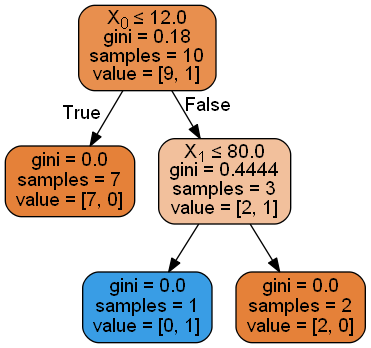

In [17]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

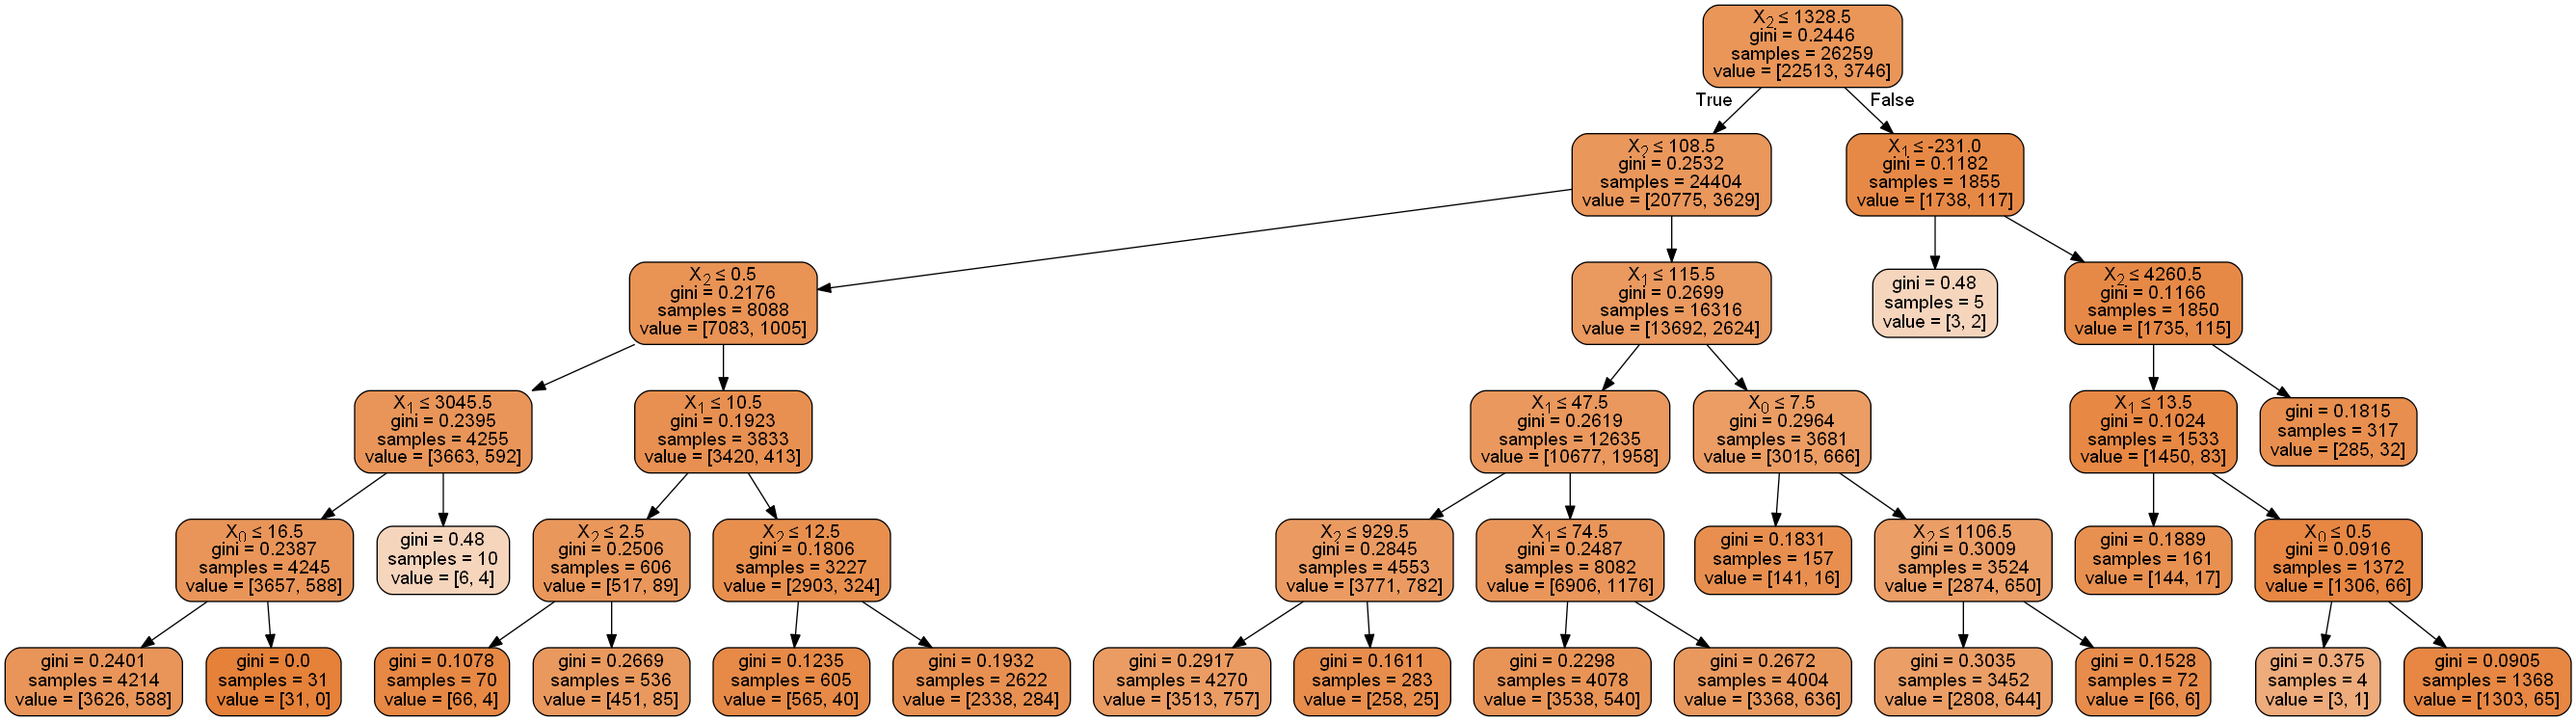

In [38]:
## Run on the whole dataset
# load in the data
s_tmpsql_all = 'select * from zTempPanAnalysis'
data_all = pd.read_sql_query(s_tmpsql_all, dbconn)
# get the repeats
y_all = data_all['IncidentType']
# get rid of the data not required
del data_all['IncidentType']
# encode the repeat data for predicion
y_repeat_all = y_all.map(lambda x: x == 'REPEAT')
# copy out the data we want
df_times_all = data_all[['AttendHour','CallMinutes','MinutesToAttend']].copy()
# replace any remaining NaN values with -1, to avoid breaking the algorithm
df_times_all = df_times_all.fillna(-1)
#print (df_times_all)
# fit a classifier
dtree_all=DecisionTreeClassifier(min_samples_split=500, max_depth=5)
dtree_all.fit(df_times_all,y_repeat_all)
# visualise
dot_data = StringIO()
export_graphviz(dtree_all, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [34]:
#df_times_all[0:10]
print(dtree_all.decision_path(df_times_all[0:10]))

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 8)	1
  (0, 12)	1
  (0, 14)	1
  (1, 0)	1
  (1, 1)	1
  (1, 15)	1
  (1, 16)	1
  (1, 20)	1
  (1, 21)	1
  (2, 0)	1
  (2, 1)	1
  (2, 2)	1
  (2, 8)	1
  (2, 12)	1
  (2, 14)	1
  (3, 0)	1
  (3, 1)	1
  (3, 15)	1
  (3, 16)	1
  (3, 20)	1
  (3, 22)	1
  (4, 0)	1
  :	:
  (5, 26)	1
  (6, 0)	1
  (6, 1)	1
  (6, 2)	1
  (6, 8)	1
  (6, 12)	1
  (6, 14)	1
  (7, 0)	1
  (7, 1)	1
  (7, 15)	1
  (7, 16)	1
  (7, 20)	1
  (7, 21)	1
  (8, 0)	1
  (8, 1)	1
  (8, 2)	1
  (8, 8)	1
  (8, 12)	1
  (8, 14)	1
  (9, 0)	1
  (9, 1)	1
  (9, 15)	1
  (9, 23)	1
  (9, 25)	1
  (9, 26)	1


## Need to do some management of the data - e.g. categoricals to IDs etc

1. Convert categorical data to IDs - e.g. engineer names, postcodes - consider if one-hot encoding is better here
2. Remove fields we don't need - e.g. redundant datatime values, incident IDs, serial numbers


In [47]:
# Count the distinct values in a categorical column
df_categorical = data_all.copy()

In [48]:
df_categorical['BusinessType'] = df_categorical['BusinessType'].astype('category')
df_categorical.dtypes

ID                                  int64
Incident                           object
CustomerId                         object
LedgerCode                         object
BusinessType                     category
SiteId                             object
MachinesOnSite                      int64
SoleMachine                          bool
Manufacturer                       object
SerialNo                           object
ProductId                          object
DeviceType                         object
Colour                               bool
AncilliariesCount                   int64
FirstUsed                  datetime64[ns]
FirstUsedDays                     float64
Installed                  datetime64[ns]
InstalledDays                     float64
PreviousBreakdowns                  int64
LastBreakCall              datetime64[ns]
LastBreakCallDays                 float64
LastOtherCall              datetime64[ns]
LastOtherCallDays                 float64
LastOtherCallType                 

In [49]:
df_categorical['BusinessType']

0                                  Manufacturing - Other
1                      Education - Secondary/High school
2                                    Housing Association
3                      Education - Secondary/High school
4                      Education - Secondary/High school
5                      Education - Secondary/High school
6                      Education - Secondary/High school
7                   Manufacturing - Chemicals/Fuels/Oils
8                      Professional - Architect/Surveyor
9                      Education - Secondary/High school
10                     Education - Junior/Primary school
11                     Education - Junior/Primary school
12                                   Housing Association
13                     Education - Secondary/High school
14       Education - University/Higher/Further education
15                       Medical - Care Home/Residential
16                     Education - Secondary/High school
17                     Educatio

In [51]:
# Creates a new column with a categorical ID generated from the existing categorical column
df_categorical['BusinessType_Categorical'] = df_categorical['BusinessType'].cat.codes

In [57]:
df_categorical['BusinessType']
df_categorical['BusinessType_Categorical']

0        18
1         5
2        13
3         5
4         5
5         5
6         5
7        16
8        27
9         5
10        3
11        3
12       13
13        5
14        6
15       21
16        5
17        5
18        2
19       -1
20       -1
21       13
22       14
23        9
24        5
25       -1
26       -1
27        1
28       21
29        5
         ..
26229     3
26230     5
26231    17
26232     5
26233     5
26234    41
26235    41
26236     3
26237    43
26238    13
26239    39
26240    13
26241    39
26242     5
26243     5
26244     5
26245     3
26246     1
26247    -1
26248     3
26249     5
26250    21
26251     5
26252     5
26253    39
26254    -1
26255     5
26256     5
26257     3
26258    39
Name: BusinessType_Categorical, Length: 26259, dtype: int8

In [58]:
data_all

,ID,Incident,CustomerId,LedgerCode,BusinessType,SiteId,MachinesOnSite,SoleMachine,Manufacturer,SerialNo,...,CreatedDateTime,CreatedTime,CreatedDay,AttendDateTime,AttendDay,AttendHour,CallMinutes,MinutesToAttend,PostCodeArea,FirstEngineer
0,1796,155059,10023,M440,Manufacturing - Other,21936,7,False,TOSHIBA,TXJF17539,...,2017-06-05 09:04:47,09:04:47,Monday,2017-06-05 10:35:00,Monday,10.0,45.0,90.0,HX7,DENNIS
1,1797,155060,12421,T278,Education - Secondary/High school,23678,16,False,TOSHIBA,CSEE19360,...,2017-06-05 09:06:07,09:06:07,Monday,2017-06-06 08:25:00,Tuesday,8.0,54.0,498.0,S65,PAULH
2,1798,155061,12190,GP114,Housing Association,24064,14,False,TOSHIBA,CMD327659,...,2017-06-05 09:06:08,09:06:08,Monday,2017-06-05 10:55:00,Monday,10.0,25.0,108.0,CH41,PHILJ
3,1799,155063,11946,C614,Education - Secondary/High school,20076,14,False,TOSHIBA,CHAG15146,...,2017-06-05 09:10:38,09:10:38,Monday,2017-06-05 14:23:00,Monday,14.0,98.0,312.0,WF4,JACOB
4,1800,155065,12571,H327,Education - Secondary/High school,20904,96,False,TOSHIBA,C7BD48186,...,2017-06-05 09:12:07,09:12:07,Monday,2017-06-05 13:14:00,Monday,13.0,111.0,241.0,HG1,DENNIS
5,1801,155066,10879,MW016,Education - Secondary/High school,24050,12,False,RICOH,W534J400076,...,2017-06-05 09:14:26,09:14:26,Monday,2017-06-06 09:15:00,Tuesday,9.0,167.0,540.0,SK9,TONY
6,1802,155067,11668,N219,Education - Secondary/High school,22131,15,False,TOSHIBA,CFLF37576,...,2017-06-05 09:18:51,09:18:51,Monday,2017-06-05 10:56:14,Monday,10.0,206.0,97.0,TS24,PETERHE
7,1803,155068,13051,E226,Manufacturing - Chemicals/Fuels/Oils,20426,5,False,TOSHIBA,C7BD46965,...,2017-06-05 09:21:56,09:21:56,Monday,2017-06-05 13:12:00,Monday,13.0,62.0,230.0,HX5,JOHNCR
8,1804,155069,11042,SH067,Professional - Architect/Surveyor,20767,4,False,TOSHIBA,C7AD42337,...,2017-06-05 09:25:31,09:25:31,Monday,2017-06-05 10:01:59,Monday,10.0,50.0,36.0,HD6,THOMAS
9,1805,155070,12046,MR002,Education - Secondary/High school,22516,3,False,XEROX,3909726530,...,2017-06-05 09:27:10,09:27:10,Monday,2017-06-05 11:47:00,Monday,11.0,143.0,139.0,OL9,JOHNST


In [60]:
df_categorical.dtypes

ID                                   int64
Incident                            object
CustomerId                          object
LedgerCode                          object
BusinessType                      category
SiteId                              object
MachinesOnSite                       int64
SoleMachine                           bool
Manufacturer                        object
SerialNo                            object
ProductId                           object
DeviceType                          object
Colour                                bool
AncilliariesCount                    int64
FirstUsed                   datetime64[ns]
FirstUsedDays                      float64
Installed                   datetime64[ns]
InstalledDays                      float64
PreviousBreakdowns                   int64
LastBreakCall               datetime64[ns]
LastBreakCallDays                  float64
LastOtherCall               datetime64[ns]
LastOtherCallDays                  float64
LastOtherCa

In [61]:
# One-hot encoding for engineers
one_hot = pd.get_dummies(data_all['FirstEngineer'])

In [63]:
one_hot[0:10]

,94,ALEXB,ALLISON,ANDREWL,ANDREWLU,BEN,CHRIS,COLIN,D-CARLM,DAN,...,SERING,STEVEM,TALIB,THOMAS,TOMF,TOMS,TONY,UNKNOWN,VICKEY,ZCALLTEST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Now join the one-hot encoded columns to the main dataframe
df_coded = df_categorical.join(one_hot)

In [65]:
df_coded[0:10]

,ID,Incident,CustomerId,LedgerCode,BusinessType,SiteId,MachinesOnSite,SoleMachine,Manufacturer,SerialNo,...,SERING,STEVEM,TALIB,THOMAS,TOMF,TOMS,TONY,UNKNOWN,VICKEY,ZCALLTEST
0,1796,155059,10023,M440,Manufacturing - Other,21936,7,False,TOSHIBA,TXJF17539,...,0,0,0,0,0,0,0,0,0,0
1,1797,155060,12421,T278,Education - Secondary/High school,23678,16,False,TOSHIBA,CSEE19360,...,0,0,0,0,0,0,0,0,0,0
2,1798,155061,12190,GP114,Housing Association,24064,14,False,TOSHIBA,CMD327659,...,0,0,0,0,0,0,0,0,0,0
3,1799,155063,11946,C614,Education - Secondary/High school,20076,14,False,TOSHIBA,CHAG15146,...,0,0,0,0,0,0,0,0,0,0
4,1800,155065,12571,H327,Education - Secondary/High school,20904,96,False,TOSHIBA,C7BD48186,...,0,0,0,0,0,0,0,0,0,0
5,1801,155066,10879,MW016,Education - Secondary/High school,24050,12,False,RICOH,W534J400076,...,0,0,0,0,0,0,1,0,0,0
6,1802,155067,11668,N219,Education - Secondary/High school,22131,15,False,TOSHIBA,CFLF37576,...,0,0,0,0,0,0,0,0,0,0
7,1803,155068,13051,E226,Manufacturing - Chemicals/Fuels/Oils,20426,5,False,TOSHIBA,C7BD46965,...,0,0,0,0,0,0,0,0,0,0
8,1804,155069,11042,SH067,Professional - Architect/Surveyor,20767,4,False,TOSHIBA,C7AD42337,...,0,0,0,1,0,0,0,0,0,0
9,1805,155070,12046,MR002,Education - Secondary/High school,22516,3,False,XEROX,3909726530,...,0,0,0,0,0,0,0,0,0,0


In [67]:
df_categorical[0:10]

,ID,Incident,CustomerId,LedgerCode,BusinessType,SiteId,MachinesOnSite,SoleMachine,Manufacturer,SerialNo,...,CreatedTime,CreatedDay,AttendDateTime,AttendDay,AttendHour,CallMinutes,MinutesToAttend,PostCodeArea,FirstEngineer,BusinessType_Categorical
0,1796,155059,10023,M440,Manufacturing - Other,21936,7,False,TOSHIBA,TXJF17539,...,09:04:47,Monday,2017-06-05 10:35:00,Monday,10.0,45.0,90.0,HX7,DENNIS,18
1,1797,155060,12421,T278,Education - Secondary/High school,23678,16,False,TOSHIBA,CSEE19360,...,09:06:07,Monday,2017-06-06 08:25:00,Tuesday,8.0,54.0,498.0,S65,PAULH,5
2,1798,155061,12190,GP114,Housing Association,24064,14,False,TOSHIBA,CMD327659,...,09:06:08,Monday,2017-06-05 10:55:00,Monday,10.0,25.0,108.0,CH41,PHILJ,13
3,1799,155063,11946,C614,Education - Secondary/High school,20076,14,False,TOSHIBA,CHAG15146,...,09:10:38,Monday,2017-06-05 14:23:00,Monday,14.0,98.0,312.0,WF4,JACOB,5
4,1800,155065,12571,H327,Education - Secondary/High school,20904,96,False,TOSHIBA,C7BD48186,...,09:12:07,Monday,2017-06-05 13:14:00,Monday,13.0,111.0,241.0,HG1,DENNIS,5
5,1801,155066,10879,MW016,Education - Secondary/High school,24050,12,False,RICOH,W534J400076,...,09:14:26,Monday,2017-06-06 09:15:00,Tuesday,9.0,167.0,540.0,SK9,TONY,5
6,1802,155067,11668,N219,Education - Secondary/High school,22131,15,False,TOSHIBA,CFLF37576,...,09:18:51,Monday,2017-06-05 10:56:14,Monday,10.0,206.0,97.0,TS24,PETERHE,5
7,1803,155068,13051,E226,Manufacturing - Chemicals/Fuels/Oils,20426,5,False,TOSHIBA,C7BD46965,...,09:21:56,Monday,2017-06-05 13:12:00,Monday,13.0,62.0,230.0,HX5,JOHNCR,16
8,1804,155069,11042,SH067,Professional - Architect/Surveyor,20767,4,False,TOSHIBA,C7AD42337,...,09:25:31,Monday,2017-06-05 10:01:59,Monday,10.0,50.0,36.0,HD6,THOMAS,27
9,1805,155070,12046,MR002,Education - Secondary/High school,22516,3,False,XEROX,3909726530,...,09:27:10,Monday,2017-06-05 11:47:00,Monday,11.0,143.0,139.0,OL9,JOHNST,5


In [68]:
data_all[0:10]

,ID,Incident,CustomerId,LedgerCode,BusinessType,SiteId,MachinesOnSite,SoleMachine,Manufacturer,SerialNo,...,CreatedDateTime,CreatedTime,CreatedDay,AttendDateTime,AttendDay,AttendHour,CallMinutes,MinutesToAttend,PostCodeArea,FirstEngineer
0,1796,155059,10023,M440,Manufacturing - Other,21936,7,False,TOSHIBA,TXJF17539,...,2017-06-05 09:04:47,09:04:47,Monday,2017-06-05 10:35:00,Monday,10.0,45.0,90.0,HX7,DENNIS
1,1797,155060,12421,T278,Education - Secondary/High school,23678,16,False,TOSHIBA,CSEE19360,...,2017-06-05 09:06:07,09:06:07,Monday,2017-06-06 08:25:00,Tuesday,8.0,54.0,498.0,S65,PAULH
2,1798,155061,12190,GP114,Housing Association,24064,14,False,TOSHIBA,CMD327659,...,2017-06-05 09:06:08,09:06:08,Monday,2017-06-05 10:55:00,Monday,10.0,25.0,108.0,CH41,PHILJ
3,1799,155063,11946,C614,Education - Secondary/High school,20076,14,False,TOSHIBA,CHAG15146,...,2017-06-05 09:10:38,09:10:38,Monday,2017-06-05 14:23:00,Monday,14.0,98.0,312.0,WF4,JACOB
4,1800,155065,12571,H327,Education - Secondary/High school,20904,96,False,TOSHIBA,C7BD48186,...,2017-06-05 09:12:07,09:12:07,Monday,2017-06-05 13:14:00,Monday,13.0,111.0,241.0,HG1,DENNIS
5,1801,155066,10879,MW016,Education - Secondary/High school,24050,12,False,RICOH,W534J400076,...,2017-06-05 09:14:26,09:14:26,Monday,2017-06-06 09:15:00,Tuesday,9.0,167.0,540.0,SK9,TONY
6,1802,155067,11668,N219,Education - Secondary/High school,22131,15,False,TOSHIBA,CFLF37576,...,2017-06-05 09:18:51,09:18:51,Monday,2017-06-05 10:56:14,Monday,10.0,206.0,97.0,TS24,PETERHE
7,1803,155068,13051,E226,Manufacturing - Chemicals/Fuels/Oils,20426,5,False,TOSHIBA,C7BD46965,...,2017-06-05 09:21:56,09:21:56,Monday,2017-06-05 13:12:00,Monday,13.0,62.0,230.0,HX5,JOHNCR
8,1804,155069,11042,SH067,Professional - Architect/Surveyor,20767,4,False,TOSHIBA,C7AD42337,...,2017-06-05 09:25:31,09:25:31,Monday,2017-06-05 10:01:59,Monday,10.0,50.0,36.0,HD6,THOMAS
9,1805,155070,12046,MR002,Education - Secondary/High school,22516,3,False,XEROX,3909726530,...,2017-06-05 09:27:10,09:27:10,Monday,2017-06-05 11:47:00,Monday,11.0,143.0,139.0,OL9,JOHNST
